In [39]:
import streamlit as st
import pandas as pd
import numpy as np
import yaml
import pyodbc
from market_growth_analysis.etl.stagging import *
import pandas as pd
import numpy as np
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine
import sys
import pandas as pd
import matplotlib.pyplot as plt

# sys.path.append('../conf') 
# Load the YAML file
with open('../../conf/global.yml', 'r') as f:
    columns = yaml.safe_load(f)

# Load the YAML file
with open('../../conf/local.yml', 'r') as f:
    credentials = yaml.safe_load(f)


# Get credentials
driver = credentials['warehouse_db']['driver']
server = credentials['warehouse_db']['server']
database = credentials['warehouse_db']['database']
trusted = credentials['warehouse_db']['trusted_connection']
user = credentials['warehouse_db']['user']
password = credentials['warehouse_db']['password']

# Create connection db
conn = pyodbc.connect('Driver={SQL Server};'
                      f'Server={server};'
                      f'Database={database};'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

In [40]:
# Get data
join_tables_query = '''
select *
from DIM_COMPANY dim
join FACT_BALANCE_SHEET bs on bs.ticker = dim.ticker
join FACT_CASH_FLOW_STATEMENT cfs on cfs.PK = bs.PK
join FACT_INCOME_STATEMENT fis on fis.PK = bs.PK
join FACT_PRICES fp on fp.PK = bs.PK
join FACT_RATIOS fr on fr.PK = bs.PK
'''
data = pd.read_sql(join_tables_query, conn)
# drop duplicated columns
data = data.T.drop_duplicates().T
data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d").dt.strftime("%Y/%m/%d")


C:\Users\germa\AppData\Local\Temp/ipykernel_13112/764186177.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(join_tables_query, conn)


In [41]:
data.columns

Index(['ticker', 'company_full_name', 'country', 'industry', 'sector', 'PK',
       'Date', 'Cash On Hand', 'Receivables', 'Inventory', 'Pre-Paid Expenses',
       'Other Current Assets', 'Total Current Assets',
       'Property, Plant, And Equipment', 'Long-Term Investments',
       'Goodwill And Intangible Assets', 'Other Long-Term Assets',
       'Total Long-Term Assets', 'Total Assets', 'Total Current Liabilities',
       'Long Term Debt', 'Other Non-Current Liabilities',
       'Total Long Term Liabilities', 'Total Liabilities', 'Common Stock Net',
       'Retained Earnings (Accumulated Deficit)', 'Comprehensive Income',
       'Other Share Holders Equity', 'Share Holder Equity',
       'Total Liabilities And Share Holders Equity', 'Net Income/Loss',
       'Total Depreciation And Amortization - Cash Flow',
       'Other Non-Cash Items', 'Total Non-Cash Items',
       'Change In Accounts Receivable', 'Change In Inventories',
       'Change In Accounts Payable', 'Change In Assets/L

In [42]:
data['country'].value_counts()

United States           39989
Canada                   1557
China                    1229
Israel                    753
United Kingdom            709
Bermuda                   443
Ireland                   354
Brazil                    350
Netherlands               194
Hong Kong, SAR China      193
Switzerland               189
Greece                    189
Argentina                 178
Germany                   150
South Korea               142
Mexico                    142
Japan                     129
Singapore                 127
India                     123
Australia                 119
Luxembourg                117
Taiwan                    117
France                    115
South Africa               94
Cayman Islands             94
Chile                      86
Colombia                   60
Spain                      56
Belgium                    54
Peru                       53
Sweden                     53
Denmark                    45
Italy                      42
Panama    

In [43]:
data['industry'].value_counts()

Medical - Biomedical and Genetics        3573
Medical - Drug Manufacturing             1682
Technology Services                      1232
Banks - Northeast                        1199
REIT - Other Equity Trusts               1165
                                         ... 
Nanotechnology Equipment and Services      11
Electronics - Military Systems             11
Retail - Mail Order & Direct                9
Printing & Trade Machinery                  8
Periodical Publishing                       2
Name: industry, Length: 252, dtype: int64

In [44]:
columns_to_study = columns['columns_prices'] + columns['columns_ratios'] + columns['column_id']

In [45]:
industry = 'Medical - Biomedical and Genetics'

data_filtered_industry = data[(data['industry'] == industry)&(data['country'] == 'United States')]

In [46]:
len(data_filtered_industry['ticker'].unique())

456

In [47]:
data_to_study = data_filtered_industry[columns_to_study]

In [48]:
data_to_study = data_to_study.dropna(subset='Growth +1')

In [49]:
data_to_study_filled = data_to_study.fillna(value=0)

In [50]:
data_to_study_filled.columns

Index(['longevity', 'Close', 'Volume', 'Growth -1', 'Growth +1', 'Growth +5',
       'Growth -10', 'Growth -5', 'Enterprise Value (EV)', 'EV / Revenue',
       'EV / EBITDA', 'EV / EBIT', 'EV / Invested Capital',
       'Free Cash Flow (FCF)', 'EV / Free Cash Flow', 'P/E', 'P/S', 'P/CF',
       'PK', 'ticker', 'Date'],
      dtype='object')

In [51]:
columns_to_drop = ['Growth +5', 
                #    'Date', 
                #    'ticker', 
                   'Close', 
                   'Volume', 
                   'longevity', 
                   'Enterprise Value (EV)', 
                   'Free Cash Flow (FCF)', 
                   'EV / EBITDA', 
                   'Growth -5', 
                   'Growth -1', 
                   'Growth -10',
                   'EV / Free Cash Flow',
                   'EV / Invested Capital'
                   ]
data_to_study_filled_drop = data_to_study_filled.drop(columns=columns_to_drop)
data_to_study_filled_drop = data_to_study_filled_drop.set_index(keys='PK')

In [52]:
data_to_study_filled_drop['Growth +1']*100

PK
4054    -54.476668
4056    -70.671142
5876    -60.640301
5812     -1.392397
5813    -17.480541
           ...    
47981   -23.132186
47984   -56.637555
47983   -64.385692
32506    33.555561
44047    57.598050
Name: Growth +1, Length: 2387, dtype: float64

In [53]:
(data_to_study_filled_drop['Growth +1']*100).describe()

count    2387.000000
mean       10.454595
std       204.415933
min       -99.444444
25%       -57.321640
50%       -20.000000
75%        27.615242
max      5346.428741
Name: Growth +1, dtype: float64

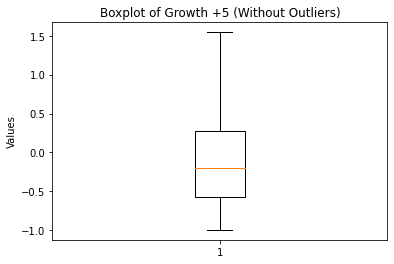

In [54]:
import matplotlib.pyplot as plt

# Assuming data_to_study_filled_drop is your DataFrame
plt.boxplot(data_to_study_filled_drop['Growth +1'], showfliers=False)
plt.title('Boxplot of Growth +5 (Without Outliers)')
plt.ylabel('Values')
plt.show()


In [55]:
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['Growth +5'] > 0
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['target'].astype(int)

import pandas as pd
import numpy as np

# Assuming you have a DataFrame named data_to_study_final
# data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
#                         np.where(data_to_study_filled_drop['Growth +5'] <= data_to_study_filled_drop['Growth +5'].quantile(0.9), 1, 2))

data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +1'] < 0, 0, 1)

# data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
#                                     np.where(data_to_study_filled_drop['Growth +5'] < 2.5, 1, 2))

num_classes = len(data_to_study_filled_drop['target'].unique())
num_classes

2

In [56]:
data_to_study_filled_drop['target'].value_counts()

0    1483
1     904
Name: target, dtype: int64

In [57]:
data_to_study_filled_drop['Growth +1'].quantile(0.9)

0.9859185476302782

In [58]:
# data_to_study_final = data_to_study_filled_drop.drop(columns='Growth +5')
data_to_study_final = data_to_study_filled_drop

In [59]:
data_to_study_final.shape

(2387, 9)

In [60]:
data_to_study_final['target'].value_counts()

0    1483
1     904
Name: target, dtype: int64

# Create LSTM Model

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Prepare Data

In [170]:
# Load your financial data into a DataFrame (replace 'your_data.csv' with your dataset)
df = data_to_study_final.copy()

# Define the sequence length and other hyperparameters
n_steps = 5 # years to study prior
# n_features = len(df.columns) - 1  # Replace with the number of feature columns in your dataset
num_companies = len(df['ticker'].unique())  # Assuming you have a 'ticker' column

# Use LabelEncoder to convert 'ticker' values to numerical labels
label_encoder = LabelEncoder()
df['ticker'] = label_encoder.fit_transform(df['ticker'])

# Prepare an empty list to store sequences for all companies
all_sequences = []
all_targets = []  # To store the corresponding target values
all_sequences_train = []
all_sequences_test = []
all_targets_train = []  # To store the corresponding target values
all_targets_test = []  # To store the corresponding target values
all_info_rows_test = []
all_info_rows_train = []

# Define the percentage of data to allocate for testing
test_size = 0.2

# Iterate through unique company labels
for label in df['ticker'].unique():
    # Filter data for the current company label
    company_data = df[df['ticker'] == label]

    # Sort data by date
    company_data_complete = company_data.sort_values(by='Date')
    company_data = company_data.sort_values(by='Date').drop(columns=['Date', 'ticker', 'Growth +1'])
    n_features = len(company_data.columns) - 1 
    # Create sequences for the current company
    sequences = []
    targets = []  # To store the corresponding target values
    info_rows = []
    sequences_train = []
    sequences_test = []
    targets_train = []
    targets_test = []
    for i in range(len(company_data) - n_steps + 1):
        sequence = company_data.iloc[i:i + n_steps, 0:n_features].values  # Adjust column indices
        target = company_data.iloc[i + n_steps - 1, n_features]  # Assuming the target column is the last one
        info_row = company_data_complete.iloc[i + n_steps - 1]
        sequences.append(sequence)
        targets.append(target)
        info_rows.append(info_row)

    # Calculate the index to split the data
    split_index = int(len(targets) * (1 - test_size))

    # Split the data into training and testing sets
    sequences_train = sequences[:split_index]
    sequences_test = sequences[split_index:]
    targets_train = targets[:split_index]
    targets_test = targets[split_index:]
    info_rows_train = info_rows[:split_index]
    info_rows_test = info_rows[split_index:]

    # Append sequences and corresponding targets to the lists
    all_sequences.extend(sequences)
    all_targets.extend(targets)
    # Append sequences and corresponding targets to the lists
    all_sequences_train.extend(sequences_train)
    all_sequences_test.extend(sequences_test)
    all_targets_train.extend(targets_train)
    all_targets_test.extend(targets_test)
    all_info_rows_train.extend(info_rows_train)
    all_info_rows_test.extend(info_rows_test)

# Split train test

In [171]:
from sklearn.model_selection import train_test_split

# # Define the percentage of data to allocate for testing
# test_size = 0.2

# # Calculate the index to split the data
# split_index = int(len(all_targets) * (1 - test_size))

# Split the data into training and testing sets
X_train, X_test = all_sequences_train, all_sequences_test
y_train, y_test = all_targets_train, all_targets_test

train_all_info, test_all_info = all_info_rows_train, all_info_rows_test

## Create Model

In [172]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the LSTM model for classification
class LSTMClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

# hyperparameters

In [173]:
# Define hyperparameters
input_size = len(all_sequences[0][0])  # Number of features in each sequence
hidden_size = 128
num_layers = 1
output_size = num_classes  # Three classes for classification (0, 1, 2)

# Create the classification model
classification_model = LSTMClassificationModel(input_size, hidden_size, num_layers, output_size)

# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.int)

# Train

In [174]:
# Train the classification model
num_epochs = 400
best_precision = 0.0  # Initialize the best precision for class 1
best_model = None

for epoch in range(num_epochs):
    outputs = classification_model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Evaluate precision on class 1 (target = 1)
    classification_model.eval()
    with torch.no_grad():
        test_outputs = classification_model(X_test)

        # Apply softmax to obtain class probabilities
        class_probs = torch.nn.functional.softmax(test_outputs, dim=1)
        _, predicted = torch.max(test_outputs, 1)  # Get the predicted class labels

        # Convert the predictions and class probabilities to numpy arrays
        y_pred = predicted.cpu().numpy()
        class_probs = class_probs.cpu().numpy()

    # Calculate precision for class 1
    precision_class_1 = precision_score(y_test, y_pred, labels=[1], average='macro')

    # Check if precision for class 1 is better than the best seen so far
    if precision_class_1 > best_precision:
        best_precision = precision_class_1
        best_model = classification_model.state_dict()
        print(f'Improved precision for class 1: {best_precision:.4f}')

# Use the best model with the highest precision for class 1
classification_model.load_state_dict(best_model)

Improved precision for class 1: 0.5333
Epoch [10/400], Loss: 0.6560
Epoch [20/400], Loss: 0.6324
Epoch [30/400], Loss: 0.6033
Epoch [40/400], Loss: 0.5656
Epoch [50/400], Loss: 0.5212
Epoch [60/400], Loss: 0.4738
Epoch [70/400], Loss: 0.4251
Epoch [80/400], Loss: 0.3772
Epoch [90/400], Loss: 0.3316
Epoch [100/400], Loss: 0.2909
Epoch [110/400], Loss: 0.2593
Epoch [120/400], Loss: 0.2246
Epoch [130/400], Loss: 0.2024
Epoch [140/400], Loss: 0.1746
Epoch [150/400], Loss: 0.1531
Epoch [160/400], Loss: 0.1385
Epoch [170/400], Loss: 0.1245
Epoch [180/400], Loss: 0.1093
Epoch [190/400], Loss: 0.1041
Epoch [200/400], Loss: 0.0913
Epoch [210/400], Loss: 0.0826
Epoch [220/400], Loss: 0.0867
Epoch [230/400], Loss: 0.0730
Epoch [240/400], Loss: 0.0635
Epoch [250/400], Loss: 0.0592
Epoch [260/400], Loss: 0.0738
Epoch [270/400], Loss: 0.0562
Epoch [280/400], Loss: 0.0500
Epoch [290/400], Loss: 0.0458
Epoch [300/400], Loss: 0.0424
Epoch [310/400], Loss: 0.0392
Epoch [320/400], Loss: 0.0364
Epoch [330

<All keys matched successfully>

# Evaluate

In [175]:
# Evaluate the classification model on the test data
classification_model.eval()
with torch.no_grad():
    test_outputs = classification_model(X_test)
    _, predicted = torch.max(test_outputs, 1)  # Get the predicted class labels

# Convert the predictions and true labels to numpy arrays
y_pred = predicted.cpu().numpy()
y_true = y_test.numpy()


In [176]:
# Filter class_probs for examples where y_pred is equal to 1
indices_class_1 = (y_pred == 1)  # Get indices where y_pred is equal to 1
class_probs_class_1 = class_probs[indices_class_1]  # Filter class_probs

# Create y_pred_mod based on class_probs_class_1
y_pred_mod = np.zeros_like(y_pred)
y_pred_mod[indices_class_1] = (class_probs_class_1[:, 1] > 0.9).astype(int)

In [177]:
(class_probs_class_1[:, 1] > 0.9)

array([False, False,  True, False,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True, False,  True, False,
        True, False,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True,  True, False,  True,  True, False,
        True, False,  True, False, False,  True, False, False, False,
        True,  True,  True, False, False,  True,  True,  True, False,
        True, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True, False, False,  True, False, False,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,

# Metrics

In [178]:
def metrics_form(y_true, y_pred):    
    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    confusion = confusion_matrix(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print('Confusion Matrix:')
    print(confusion)

In [179]:
# Calculate classification metrics
metrics_form(y_true, y_pred)

Accuracy: 0.5552
Precision: 0.5395
Recall: 0.5532
F1-score: 0.5155
Confusion Matrix:
[[122  97]
 [ 32  39]]


In [180]:
# Calculate classification metrics
metrics_form(y_true, y_pred_mod)

Accuracy: 0.6103
Precision: 0.5078
Recall: 0.5088
F1-score: 0.5066
Confusion Matrix:
[[155  64]
 [ 49  22]]


In [181]:
# Calculate precision for class 1
precision_class_1 = precision_score(y_true, y_pred, labels=[1], average='macro')
precision_class_1

0.2867647058823529

In [182]:
# Calculate precision for class 1
precision_class_1 = precision_score(y_true, y_pred_mod, labels=[1], average='macro')
precision_class_1

0.2558139534883721

In [183]:
# Calculate precision for class 1
recall_class_1 = recall_score(y_true, y_pred, labels=[1], average='macro')
recall_class_1

0.5492957746478874

In [184]:
# Calculate precision for class 1
recall_class_1 = recall_score(y_true, y_pred_mod, labels=[1], average='macro')
recall_class_1

0.30985915492957744